In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "..")
sys.path.insert(0, "../..")

# Excited states with DANN (PaiNN + diabatization)
This tutorial gives an example of implementing the [equivariant PaiNN architecture](https://arxiv.org/pdf/2102.03150.pdf) for excited states. We'll use the diabatization method that forms the basis of the [DANN model](https://arxiv.org/pdf/2108.04879.pdf).

First we import dependencies for the tutorial:

In [2]:
import sys
from pathlib import Path

# so that NFF is in your path
sys.path.insert(0, "..")

import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import copy

import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.data.sampler import RandomSampler


from nff.data import Dataset, split_train_validation_test, collate_dicts, to_tensor
from nff.train import Trainer, get_trainer, get_model, load_model, loss, hooks, metrics, evaluate


## Loss function

Let's make a loss function for the model. We'll use three diabatic states, so that the model outputs the six quantities `d_{ij}` for `i >= j`, and `0 <= i, j <= 2`. That means the model outputs `d_00`, `d_01`, etc. The model will then produce three adiabatic energies, `energy_{i}`. Last, the model will also run a backwards pass to produce the gradients `energy_{i}_grad`.

The loss function can penalize errors in the adiabatic energies and forces, adiabatic gaps, and non-adiabatic couplings (NACV). It can also penalize errors in the `d_{i}{i}`, provided that a set of reference geometries with known `d_{i}{i}` is in the dataset. 


The loss function can be created using a dictionary:

In [3]:
loss_dict = {
    "mse": [
        {
            "coef": 0.01,
            "params": {
                "key": "d_00"
            }
        },
        {
            "coef": 0.01,
            "params": {
                "key": "d_11"
            }
        },
        {
            "coef": 0.01,
            "params": {
                "key": "d_22"
            }
        },
        {
            "coef": 0.2,
            "params": {
                "key": "energy_0"
            }
        },
        {
            "coef": 1,
            "params": {
                "key": "energy_0_grad"
            }
        },
        {
            "coef": 0.1,
            "params": {
                "key": "energy_1"
            }
        },
        {
            "coef": 1,
            "params": {
                "key": "energy_1_grad"
            }
        },
        {
            "coef": 0.5,
            "params": {
                "key": "energy_1_energy_0_delta"
            }
        }
    ],
    "nacv": [
        {
            "coef": 1,
            "params": {
                "abs": False,
                "key": "force_nacv_10",
                "max": False
            }
        }
    ]
}

We see that each key is a different type of loss (e.g. `mse` for mean-squared-error), and each value is a list of sub-dictionaries. Each sub-dictionary contains information about the quantities being penalized, through `params`, and their relative weights, through `coef`. For example, `d_11` is through with an MSE loss with weight 0.01. Some notes:

- The NACV gets its own special loss type, called `nacv`. This is because it must correct the phase of the predicted NACV to minimize the prediction error. This accounts for random sign changes in the ground truth NACV.

- Energy gaps in the dataset are denoted `energy_{i}_energy_{j}_delta`, where i > j.  

- Force NACVS in the dataset are denoted `force_nacv_{i}_energy_{j}_delta`, where i > j.  

Now we can supply the loss dictionary to `loss.build_multi_loss`, and we have our loss funnction:

In [4]:
loss_fn = loss.build_multi_loss(loss_dict)



## Making the model

Now let's make the actual model. To do this we can use `get_model`, together with the model parameters and model type. 

Our model type is called `PainnDiabat`, because it's PaiNN with diabatic states. We'll also have to supply the keys below, which include the regular hyperparameters (activation function, feature dimension, etc.), as well as the keys of the diabatic energies. We'll also specify `add_nacv=True`, which means the NACV will get computed when the model is called, and hence can be used in the loss function:


In [5]:
# Only provide the 6 unique diabatic keys
# It doesn't matter whether you use upper- or lower-triangular

diabat_keys = [['d_00', 'd_01', 'd_02'],
               ['d_01', 'd_11', 'd_12'],
               ['d_02', 'd_12', 'd_22']]

modelparams = {
              "feat_dim": 128,
              "activation": "swish",
              "n_rbf": 20,
              "cutoff": 5.0,
              "num_conv": 3,
              "output_keys": ["energy_0",
                             "energy_1"],
              "grad_keys": ["energy_0_grad",
                           "energy_1_grad"],
              "diabat_keys": diabat_keys,
              "add_nacv": True
              }

model = get_model(modelparams, model_type="PainnDiabat")

## Optimizer, metrics, and hooks

Now we create the optimizer, metrics, and hooks, just like we do for regular models. For metrics we'll monitor the energies and forces of each state, as well as the gap:

In [6]:
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = Adam(trainable_params, lr=1e-4)

train_metrics = [
    metrics.MeanAbsoluteError('energy_0'),
    metrics.MeanAbsoluteError('energy_1'),
    metrics.MeanAbsoluteError('energy_0_grad'),
    metrics.MeanAbsoluteError('energy_1_grad'),
    metrics.MeanAbsoluteError('energy_1_energy_0_delta')
]


outdir = 'sandbox_excited'
train_hooks = [
    hooks.CSVHook(
        outdir,
        metrics=train_metrics,
    ),
    hooks.PrintingHook(
        outdir,
        metrics=train_metrics,
        separator = ' | ',
        time_strf='%M:%S'
    ),
    hooks.ReduceLROnPlateauHook(
        optimizer=optimizer,
        # patience in the original paper
        patience=50,
        factor=0.5,
        min_lr=1e-7,
        window_length=1,
        stop_after_min=True
    )
]




## Dataset

The last thing we have to do before training is load the dataset. For the tutorial we have a pre-baked dataset saved in `data`. So all we have to do is load it, split it, and make data loaders:

In [7]:
dset = Dataset.from_file('data/azo_diabat.pth.tar')
train, val, test = split_train_validation_test(dset, val_size=0.1, test_size=0.1)

batch_size = 20
train_loader = DataLoader(train, 
                          batch_size=batch_size, 
                          collate_fn=collate_dicts,
                          sampler=RandomSampler(train))

val_loader = DataLoader(val, 
                        batch_size=batch_size, 
                        collate_fn=collate_dicts)

test_loader = DataLoader(test, 
                         batch_size=batch_size, 
                         collate_fn=collate_dicts)




## Training

Now we're ready to train!

In [8]:
import shutil

if os.path.isdir(outdir):
    if os.path.isdir('backup'):
        shutil.rmtree('backup')
    shutil.move(outdir, 'backup')
    
T = Trainer(
    model_path=outdir,
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_loader=train_loader,
    validation_loader=val_loader,
    checkpoint_interval=1,
    hooks=train_hooks,
    mini_batches=1
)

device = 3
T.train(device=device, n_epochs=200)



 Time | Epoch | Learning rate | Train loss | Validation loss | MAE_energy_0 | MAE_energy_1 | MAE_energy_0_grad | MAE_energy_1_grad | MAE_energy_1_energy_0_delta | GPU Memory (MB)


  0%|                                                                                                                                                                          | 0/40 [00:00<?, ?it/s]../nff/nn/modules/diabat.py:141: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L') (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2500.)
  ad_energies, u = torch.symeig(d_mat, True)
 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

13:56 |     1 |     1.000e-04 |  2111.4878 |       1735.8527 |      18.8310 |      19.6362 |           16.6401 |           14.1026 |                     10.7071 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.50it/s]


14:06 |     2 |     1.000e-04 |  1135.4320 |       1033.6940 |      13.2661 |      11.6572 |           12.3916 |           10.8612 |                     13.0571 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.78it/s]


14:14 |     3 |     1.000e-04 |   840.6682 |        852.3994 |      11.2339 |      10.4717 |           10.9570 |            9.6645 |                     12.0755 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:09<00:00,  4.28it/s]


14:24 |     4 |     1.000e-04 |   725.8606 |        752.9040 |       9.7626 |       8.6895 |           10.0090 |            9.3205 |                     11.8750 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.57it/s]


14:33 |     5 |     1.000e-04 |   625.1125 |        683.1296 |       9.3874 |       7.5342 |            9.0314 |            8.7449 |                      9.6182 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.69it/s]


14:42 |     6 |     1.000e-04 |   556.7177 |        621.4272 |       8.3224 |       7.5540 |            8.5257 |            7.9145 |                     10.5626 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:09<00:00,  4.12it/s]


14:53 |     7 |     1.000e-04 |   566.5124 |        566.2953 |       8.4519 |       9.0273 |            8.1768 |            7.0946 |                      9.2217 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:09<00:00,  4.16it/s]


15:03 |     8 |     1.000e-04 |   514.0202 |        529.3915 |       7.8152 |       6.8070 |            7.6095 |            6.9861 |                      9.3679 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.72it/s]


15:12 |     9 |     1.000e-04 |   473.3568 |        562.3485 |       9.1626 |       8.9965 |            7.4465 |            6.8346 |                     14.9090 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.74it/s]


15:21 |    10 |     1.000e-04 |   448.7978 |        486.8221 |       8.9753 |       5.9934 |            7.2080 |            6.4789 |                     11.2572 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.80it/s]


15:29 |    11 |     1.000e-04 |   427.2583 |        439.4668 |       7.4986 |       5.3477 |            7.1047 |            6.0716 |                      8.3917 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.87it/s]


15:38 |    12 |     1.000e-04 |   498.1728 |        465.1480 |       8.0461 |       7.9902 |            7.0248 |            6.2294 |                      7.1493 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.76it/s]


15:47 |    13 |     1.000e-04 |   428.4284 |        426.5741 |       7.8210 |       5.4941 |            6.6489 |            5.9179 |                      7.5530 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.45it/s]


15:56 |    14 |     1.000e-04 |   392.6013 |        416.8704 |       7.1511 |       5.1604 |            6.9460 |            5.8297 |                      6.6297 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.48it/s]


16:06 |    15 |     1.000e-04 |   377.1327 |        394.9555 |       6.3147 |       6.1074 |            6.4796 |            5.8206 |                      8.9498 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:07<00:00,  4.88it/s]


16:14 |    16 |     1.000e-04 |   346.9325 |        379.2437 |       6.0975 |       4.7600 |            6.4397 |            5.8088 |                      7.6142 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.81it/s]


16:23 |    17 |     1.000e-04 |   330.6991 |        378.6608 |      11.3036 |       6.8174 |            6.1315 |            5.5190 |                      8.0776 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.62it/s]


16:32 |    18 |     1.000e-04 |   301.4913 |        313.9661 |       4.9033 |       4.0663 |            5.9904 |            5.5542 |                      5.0746 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.72it/s]


16:41 |    19 |     1.000e-04 |   330.8401 |        306.2290 |       5.4713 |       4.4629 |            6.0255 |            5.3827 |                      6.1355 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:09<00:00,  4.28it/s]


16:51 |    20 |     1.000e-04 |   283.3976 |        309.3203 |       6.3518 |       5.0741 |            5.6855 |            5.2239 |                      8.5156 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.82it/s]


17:00 |    21 |     1.000e-04 |   266.1319 |        297.6751 |       6.0124 |       5.9923 |            5.3626 |            5.0338 |                      9.6432 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:09<00:00,  4.20it/s]


17:10 |    22 |     1.000e-04 |   300.3185 |        313.5197 |       4.5132 |       4.5346 |            5.7889 |            5.3924 |                      4.5660 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:09<00:00,  4.11it/s]


17:20 |    23 |     1.000e-04 |   525.3086 |        318.5919 |       8.4677 |       5.5712 |            5.9193 |            5.5362 |                      6.8144 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:09<00:00,  4.00it/s]


17:30 |    24 |     1.000e-04 |   293.2599 |        310.5901 |       4.6601 |       4.7444 |            5.8680 |            5.5462 |                      4.3581 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:09<00:00,  4.02it/s]


17:41 |    25 |     1.000e-04 |   236.4978 |        246.5908 |       4.6758 |       4.3546 |            5.2553 |            4.9774 |                      5.7829 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:09<00:00,  4.13it/s]


17:51 |    26 |     1.000e-04 |   214.6204 |        241.3646 |       4.0620 |       3.7127 |            5.2189 |            4.9926 |                      3.1520 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.38it/s]


18:00 |    27 |     1.000e-04 |   234.5953 |        273.4394 |       5.0219 |       6.0028 |            5.1291 |            4.9034 |                      8.8461 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.49it/s]


18:10 |    28 |     1.000e-04 |   211.1802 |        221.1842 |       3.8250 |       4.2250 |            4.9412 |            4.6711 |                      4.9545 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.66it/s]


18:19 |    29 |     1.000e-04 |   239.5134 |        244.2042 |       4.3147 |       4.5735 |            5.1727 |            4.9508 |                      2.6464 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.35it/s]


18:29 |    30 |     1.000e-04 |   227.5232 |        217.2256 |       4.4104 |       4.8573 |            4.8930 |            4.7983 |                      2.9935 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.60it/s]


18:38 |    31 |     1.000e-04 |   222.1035 |        230.3625 |       3.7276 |       4.9559 |            5.0249 |            4.7400 |                      3.9046 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.63it/s]


18:47 |    32 |     1.000e-04 |   251.0296 |        227.0673 |       3.8727 |       7.7476 |            4.8645 |            4.6473 |                      5.9819 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.46it/s]


18:56 |    33 |     1.000e-04 |   206.3243 |        231.9275 |       6.8564 |       5.1599 |            4.9080 |            4.7492 |                      3.3599 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.34it/s]


19:06 |    34 |     1.000e-04 |   191.1068 |        236.7591 |       4.1120 |       4.9110 |            4.8562 |            4.5874 |                      6.6113 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.61it/s]


19:15 |    35 |     1.000e-04 |   220.4868 |        317.8971 |       6.6967 |       7.3529 |            5.0536 |            4.7208 |                     12.2062 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.77it/s]


19:24 |    36 |     1.000e-04 |   271.0138 |        269.1107 |       4.6832 |       6.3809 |            4.8581 |            4.7288 |                      8.8069 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.69it/s]


19:33 |    37 |     1.000e-04 |   200.1410 |        240.7130 |       3.6159 |       8.9798 |            4.7732 |            4.5661 |                      7.3587 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.74it/s]


19:42 |    38 |     1.000e-04 |   199.5263 |        218.9244 |       3.2940 |       6.4162 |            4.7157 |            4.5265 |                      4.8592 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.76it/s]


19:50 |    39 |     1.000e-04 |   178.7079 |        200.9382 |       3.3214 |       3.3515 |            4.6472 |            4.5120 |                      2.7935 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.70it/s]


19:59 |    40 |     1.000e-04 |   189.2787 |        191.6633 |       4.1407 |       3.8067 |            4.5648 |            4.3390 |                      2.7221 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.65it/s]


20:08 |    41 |     1.000e-04 |   182.9431 |        190.9055 |       3.0832 |       3.5807 |            4.5635 |            4.2944 |                      2.9920 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:07<00:00,  4.89it/s]


20:17 |    42 |     1.000e-04 |   198.3349 |        175.3135 |       3.1933 |       3.3828 |            4.3378 |            4.2819 |                      2.2708 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.74it/s]


20:26 |    43 |     1.000e-04 |   167.6830 |        265.7532 |       3.1779 |       3.9248 |            5.1643 |            5.0359 |                      2.8229 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.55it/s]


20:35 |    44 |     1.000e-04 |   189.9863 |        189.6123 |       3.5142 |       3.8637 |            4.5116 |            4.3680 |                      2.3129 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.68it/s]


20:44 |    45 |     1.000e-04 |   185.4055 |        165.1193 |       4.3318 |       4.1645 |            4.1686 |            4.0778 |                      1.9547 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.70it/s]


20:53 |    46 |     1.000e-04 |   174.3957 |        164.7990 |       2.9826 |       4.1697 |            4.2789 |            4.1155 |                      2.5043 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.81it/s]


21:02 |    47 |     1.000e-04 |   166.0711 |        186.3939 |       3.1797 |       6.1459 |            4.3401 |            4.2216 |                      4.0652 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:09<00:00,  4.25it/s]


21:12 |    48 |     1.000e-04 |   163.1453 |        203.5185 |       2.8346 |       3.4017 |            4.6312 |            4.4409 |                      2.4763 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:09<00:00,  4.11it/s]


21:22 |    49 |     1.000e-04 |   173.6782 |        336.6893 |       6.0297 |       8.2984 |            4.9324 |            4.6967 |                     12.8225 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:09<00:00,  4.26it/s]


21:32 |    50 |     1.000e-04 |   274.4158 |        233.8892 |       7.2906 |      10.0296 |            4.7597 |            4.4423 |                      5.0323 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.40it/s]


21:41 |    51 |     1.000e-04 |   214.1261 |        446.4424 |       6.8679 |       9.6950 |            5.5049 |            5.1889 |                     15.3973 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:09<00:00,  4.20it/s]


21:51 |    52 |     1.000e-04 |   233.4769 |        195.3380 |       3.9470 |       6.5922 |            4.4584 |            4.2807 |                      4.1886 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.42it/s]


22:00 |    53 |     1.000e-04 |   157.7203 |        178.3651 |       3.2126 |       3.2790 |            4.3841 |            4.1220 |                      2.1991 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.60it/s]


22:10 |    54 |     1.000e-04 |   164.9476 |        178.6204 |       4.8390 |       3.3208 |            4.2025 |            4.0502 |                      4.5168 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.67it/s]


22:19 |    55 |     1.000e-04 |   183.3281 |        247.9378 |       3.9330 |       5.8740 |            4.9624 |            4.3887 |                      6.8056 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.59it/s]


22:28 |    56 |     1.000e-04 |   173.4576 |        160.7163 |       4.4882 |       5.4596 |            4.0959 |            3.9886 |                      2.3096 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:09<00:00,  4.10it/s]


22:38 |    57 |     1.000e-04 |   156.9219 |        169.0212 |       3.0556 |       4.2240 |            4.1660 |            4.0908 |                      2.5247 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:09<00:00,  4.24it/s]


22:48 |    58 |     1.000e-04 |   154.6699 |        165.2414 |       2.7951 |       3.3382 |            4.1747 |            4.0583 |                      2.1760 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:09<00:00,  4.33it/s]


22:58 |    59 |     1.000e-04 |   175.6599 |        200.4798 |       2.9079 |       5.6465 |            4.3345 |            4.2510 |                      5.8356 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.51it/s]


23:07 |    60 |     1.000e-04 |   178.3587 |        164.3642 |       3.1326 |       3.5507 |            4.1514 |            4.0273 |                      2.8301 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.57it/s]


23:16 |    61 |     1.000e-04 |   192.4102 |        143.1797 |       2.8715 |       3.2741 |            3.9379 |            3.8483 |                      1.6625 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.56it/s]


23:25 |    62 |     1.000e-04 |   140.3487 |        173.1658 |       2.8186 |       5.6633 |            4.1314 |            3.9952 |                      4.6469 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.57it/s]


23:35 |    63 |     1.000e-04 |   151.3375 |        152.7383 |       5.6850 |       4.9151 |            3.9138 |            3.8530 |                      2.0822 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.84it/s]


23:43 |    64 |     1.000e-04 |   151.1958 |        146.1901 |       2.9671 |       3.1005 |            3.8942 |            3.8683 |                      2.0115 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.75it/s]


23:52 |    65 |     1.000e-04 |   151.3185 |        207.3766 |       5.1886 |       3.4031 |            4.3265 |            4.1979 |                      5.0549 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.67it/s]


24:01 |    66 |     1.000e-04 |   149.3638 |        148.2244 |       2.6257 |       3.1786 |            3.9372 |            3.8100 |                      1.9682 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.37it/s]


24:11 |    67 |     1.000e-04 |   157.0293 |        190.2223 |       3.0382 |       5.0727 |            4.2400 |            4.1104 |                      4.4207 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.58it/s]


24:20 |    68 |     1.000e-04 |   163.8824 |        173.5455 |       4.7260 |       5.3037 |            4.3117 |            4.0452 |                      2.7069 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.65it/s]


24:29 |    69 |     1.000e-04 |   160.4844 |        173.3175 |       4.2615 |       6.6473 |            4.1503 |            4.0268 |                      2.9051 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.58it/s]


24:38 |    70 |     1.000e-04 |   156.6947 |        176.9654 |       5.6500 |       4.2531 |            4.1637 |            4.0684 |                      2.9427 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.63it/s]


24:47 |    71 |     1.000e-04 |   155.9165 |        266.4853 |       6.6116 |      14.2697 |            4.4888 |            4.5006 |                      9.0902 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.66it/s]


24:56 |    72 |     1.000e-04 |   166.8242 |        191.1315 |       5.2322 |       3.5531 |            4.1764 |            4.0329 |                      5.9440 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.57it/s]


25:05 |    73 |     1.000e-04 |   152.5391 |        166.7089 |       5.9574 |       3.6275 |            4.0316 |            3.8839 |                      3.6581 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.39it/s]


25:15 |    74 |     1.000e-04 |   157.3551 |        156.9026 |       2.7407 |       3.1233 |            4.1139 |            3.9098 |                      1.7841 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.56it/s]


25:24 |    75 |     1.000e-04 |   134.2047 |        207.5310 |       5.9401 |       5.2787 |            4.4323 |            4.3114 |                      2.2731 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.54it/s]


25:33 |    76 |     1.000e-04 |   148.9651 |        148.2538 |       2.8499 |       3.1576 |            3.9388 |            3.9141 |                      2.1567 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.38it/s]


25:43 |    77 |     1.000e-04 |   144.8098 |        192.1433 |       2.6726 |       6.5031 |            4.2147 |            4.0142 |                      5.4717 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.55it/s]


25:52 |    78 |     1.000e-04 |   127.2419 |        149.8434 |       5.0136 |       5.2983 |            3.8323 |            3.7977 |                      1.6440 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.44it/s]


26:02 |    79 |     1.000e-04 |   140.0606 |        147.5042 |       4.2707 |       3.4296 |            3.7858 |            3.7863 |                      2.0278 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.53it/s]


26:11 |    80 |     1.000e-04 |   137.9189 |        163.8047 |       3.1949 |       5.7075 |            3.9762 |            3.8295 |                      4.2354 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.54it/s]


26:20 |    81 |     1.000e-04 |   137.0818 |        177.2715 |       2.9386 |       5.0106 |            4.0789 |            3.8823 |                      5.8079 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.71it/s]


26:29 |    82 |     1.000e-04 |   135.3539 |        136.9761 |       2.8651 |       4.0501 |            3.6873 |            3.6632 |                      1.8672 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.58it/s]


26:38 |    83 |     1.000e-04 |   134.3777 |        176.1669 |       4.2326 |       9.3779 |            3.7791 |            3.8137 |                      5.9664 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.67it/s]


26:47 |    84 |     1.000e-04 |   237.6961 |        169.0630 |       3.3039 |       3.6685 |            4.1721 |            3.9500 |                      2.9743 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.53it/s]


26:57 |    85 |     1.000e-04 |   138.3315 |        135.1462 |       2.7212 |       3.0634 |            3.7078 |            3.6501 |                      1.7711 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.54it/s]


27:06 |    86 |     1.000e-04 |   141.2842 |        153.5835 |       4.0027 |       6.5936 |            3.8114 |            3.7943 |                      3.4328 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.67it/s]


27:15 |    87 |     1.000e-04 |   129.4873 |        173.2593 |       4.3364 |       4.6323 |            3.7888 |            3.7531 |                      7.1909 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.72it/s]


27:24 |    88 |     1.000e-04 |   123.5027 |        148.2577 |       3.0934 |       3.0048 |            3.8226 |            3.7427 |                      2.7083 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.61it/s]


27:33 |    89 |     1.000e-04 |   127.2639 |        147.3186 |       2.7485 |       3.2881 |            3.7425 |            3.7225 |                      3.2300 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:09<00:00,  4.21it/s]


27:43 |    90 |     1.000e-04 |   115.7350 |        153.9494 |       4.3189 |       2.7858 |            3.7826 |            3.7274 |                      4.0141 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:10<00:00,  3.70it/s]


27:54 |    91 |     1.000e-04 |   146.0499 |        165.9869 |       2.8906 |       3.5174 |            3.9346 |            3.9302 |                      1.9478 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:10<00:00,  3.72it/s]


28:06 |    92 |     1.000e-04 |   576.9958 |        823.8671 |       8.0407 |      15.6768 |            9.5354 |            7.5005 |                     20.2158 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.38it/s]


28:15 |    93 |     1.000e-04 |   619.9113 |        420.7852 |       6.3794 |       4.7136 |            6.5409 |            5.7487 |                      7.4153 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:09<00:00,  4.25it/s]


28:25 |    94 |     1.000e-04 |   406.2249 |        352.7890 |       5.3244 |       5.2343 |            5.6354 |            5.3328 |                      7.5414 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.41it/s]


28:35 |    95 |     1.000e-04 |   336.2491 |        279.9611 |       4.7639 |       3.6088 |            5.2163 |            5.0791 |                      3.6580 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:09<00:00,  4.09it/s]


28:45 |    96 |     1.000e-04 |   282.1045 |        269.1128 |       4.2201 |       3.7528 |            5.1411 |            5.0669 |                      2.9964 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:09<00:00,  4.32it/s]


28:55 |    97 |     1.000e-04 |   283.1724 |        242.1316 |       3.5709 |       4.3842 |            4.8144 |            4.7994 |                      4.0361 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.53it/s]


29:04 |    98 |     1.000e-04 |   222.7099 |        238.7425 |       4.6381 |       3.8596 |            4.8149 |            4.7960 |                      2.9640 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.45it/s]


29:13 |    99 |     1.000e-04 |   222.4187 |        207.0649 |       3.4139 |       4.1844 |            4.5072 |            4.5196 |                      2.6025 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.54it/s]


29:23 |   100 |     1.000e-04 |   204.8997 |        304.7763 |       3.7834 |       4.9424 |            5.2117 |            5.1133 |                      6.4493 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.40it/s]


29:32 |   101 |     1.000e-04 |   213.7912 |        210.2890 |       3.2196 |       3.2951 |            4.5748 |            4.5379 |                      2.7408 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:09<00:00,  4.21it/s]


29:42 |   102 |     1.000e-04 |   203.7732 |        214.9976 |       2.7655 |       3.7432 |            4.6649 |            4.5590 |                      2.8822 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:09<00:00,  4.28it/s]


29:52 |   103 |     1.000e-04 |   196.8502 |        181.2360 |       2.9079 |       2.9904 |            4.2768 |            4.2531 |                      2.3242 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:10<00:00,  3.78it/s]


30:03 |   104 |     1.000e-04 |   200.9990 |        201.9334 |       3.3840 |       3.2512 |            4.5139 |            4.3372 |                      2.8271 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.54it/s]


30:13 |   105 |     1.000e-04 |   178.8357 |        176.7706 |       2.8406 |       3.7702 |            4.2083 |            4.1670 |                      3.0703 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.45it/s]


30:22 |   106 |     1.000e-04 |   220.6035 |        253.5047 |       5.5479 |       5.4340 |            4.5427 |            4.4851 |                      9.0131 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.49it/s]


30:31 |   107 |     1.000e-04 |   373.2060 |        260.2129 |       6.2579 |       4.2637 |            5.0240 |            5.0494 |                      5.7499 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.50it/s]


30:41 |   108 |     1.000e-04 |   203.1705 |        171.6319 |       2.9619 |       2.9195 |            4.1692 |            4.2114 |                      2.2121 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.63it/s]


30:50 |   109 |     1.000e-04 |   331.0056 |        222.2603 |       4.4165 |       4.1494 |            4.5786 |            4.4588 |                      6.5392 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.74it/s]


30:59 |   110 |     1.000e-04 |   180.0928 |        179.5080 |       3.0357 |       3.0236 |            4.2332 |            4.2222 |                      2.3888 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.42it/s]


31:08 |   111 |     1.000e-04 |   256.5929 |        205.1382 |       3.6710 |       4.1468 |            4.4554 |            4.5287 |                      3.0909 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:09<00:00,  4.23it/s]


31:18 |   112 |     1.000e-04 |   209.6438 |        192.7677 |       3.4969 |       4.2997 |            4.2971 |            4.1682 |                      5.5287 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.58it/s]


31:27 |   113 |     1.000e-04 |   192.3229 |        195.7203 |       3.8518 |       4.1133 |            4.3537 |            4.2075 |                      5.1590 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.52it/s]


31:36 |   114 |     1.000e-04 |   173.4647 |        159.4087 |       3.0127 |       2.9375 |            4.0391 |            4.0051 |                      1.8836 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.59it/s]


31:46 |   115 |     1.000e-04 |   166.3143 |        170.7519 |       2.6126 |       3.2680 |            4.1803 |            4.0698 |                      2.2578 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.59it/s]


31:55 |   116 |     1.000e-04 |   150.3895 |        161.6531 |       2.8652 |       2.8664 |            3.9774 |            4.0248 |                      1.9644 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:09<00:00,  4.30it/s]


32:04 |   117 |     1.000e-04 |   158.8180 |        176.6628 |       3.5446 |       4.3901 |            4.1741 |            4.0944 |                      2.3915 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:09<00:00,  4.27it/s]


32:14 |   118 |     1.000e-04 |   157.5622 |        179.3688 |       2.8145 |       5.1492 |            4.0279 |            4.0096 |                      5.2060 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:10<00:00,  3.74it/s]


32:26 |   119 |     1.000e-04 |   162.7630 |        153.6534 |       2.6319 |       2.8819 |            3.9270 |            3.9299 |                      1.5938 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:09<00:00,  4.00it/s]


32:36 |   120 |     1.000e-04 |   155.1544 |        159.7351 |       2.7942 |       3.3014 |            4.0311 |            3.9597 |                      2.4154 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.64it/s]


32:45 |   121 |     1.000e-04 |   146.2904 |        151.4668 |       2.6501 |       2.8506 |            3.8901 |            3.8356 |                      1.8930 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:09<00:00,  4.16it/s]


32:55 |   122 |     1.000e-04 |   252.4157 |        171.2713 |       3.0969 |       3.7885 |            4.1671 |            4.0309 |                      2.4645 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.46it/s]


33:05 |   123 |     1.000e-04 |   148.7208 |        151.1631 |       2.5411 |       2.7659 |            3.9092 |            3.8537 |                      1.9315 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.45it/s]


33:14 |   124 |     1.000e-04 |   148.2387 |        199.5797 |       3.0627 |       2.9337 |            4.3582 |            4.1852 |                      2.6222 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:09<00:00,  4.29it/s]


33:24 |   125 |     1.000e-04 |   155.4718 |        186.2095 |       2.6285 |       6.1445 |            4.1089 |            4.0274 |                      5.7930 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.55it/s]


33:33 |   126 |     1.000e-04 |   172.5430 |        166.9273 |       2.9985 |       3.2542 |            4.1054 |            4.0055 |                      2.1459 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.44it/s]


33:42 |   127 |     1.000e-04 |   189.8106 |        169.0139 |       4.3688 |       4.8932 |            3.9870 |            4.0736 |                      2.3341 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.50it/s]


33:52 |   128 |     1.000e-04 |   144.3858 |        149.8553 |       2.5229 |       3.4390 |            3.8333 |            3.8064 |                      2.0793 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.55it/s]


34:01 |   129 |     1.000e-04 |   147.3613 |        173.0419 |       2.4780 |       5.6325 |            3.9364 |            3.8953 |                      5.4506 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:09<00:00,  4.32it/s]


34:11 |   130 |     1.000e-04 |   142.2846 |        153.4943 |       2.6934 |       2.7694 |            3.8885 |            3.8501 |                      1.9112 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:09<00:00,  4.21it/s]


34:21 |   131 |     1.000e-04 |   142.5592 |        163.2822 |       2.9198 |       4.7781 |            3.8977 |            3.9035 |                      3.5780 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.47it/s]


34:30 |   132 |     1.000e-04 |   152.3336 |        143.3814 |       2.6931 |       2.9721 |            3.7075 |            3.7213 |                      1.7118 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.42it/s]


34:40 |   133 |     1.000e-04 |   235.5153 |        174.4537 |       2.5703 |       5.0439 |            4.0634 |            3.8872 |                      4.1341 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.45it/s]


34:49 |   134 |     1.000e-04 |   168.0266 |        168.4851 |       2.9489 |       3.6649 |            3.8860 |            4.0270 |                      3.2838 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:09<00:00,  3.97it/s]


35:00 |   135 |     1.000e-04 |   137.6654 |        148.4508 |       2.6672 |       2.8285 |            3.8057 |            3.7415 |                      1.7947 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:09<00:00,  4.11it/s]


35:10 |   136 |     1.000e-04 |   139.1351 |        135.6723 |       2.4104 |       2.7393 |            3.6380 |            3.5997 |                      1.6807 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:09<00:00,  4.01it/s]


35:21 |   137 |     5.000e-05 |   162.8227 |        193.3321 |       3.4332 |       4.3146 |            4.1909 |            4.0046 |                      5.4151 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.55it/s]


35:30 |   138 |     5.000e-05 |   160.8097 |        170.2084 |       3.4466 |       3.9039 |            3.9364 |            3.9265 |                      2.6498 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.35it/s]


35:39 |   139 |     5.000e-05 |   119.6612 |        195.4911 |       2.3817 |       3.0436 |            4.1931 |            4.1567 |                      2.2654 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:09<00:00,  4.28it/s]


35:49 |   140 |     5.000e-05 |   131.2031 |        143.1473 |       2.9474 |       2.8426 |            3.6313 |            3.6783 |                      2.6319 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:09<00:00,  4.19it/s]


35:59 |   141 |     5.000e-05 |   119.0545 |        132.4246 |       2.4405 |       2.7159 |            3.5614 |            3.5579 |                      1.5088 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.64it/s]


36:08 |   142 |     5.000e-05 |   118.8917 |        177.9996 |       3.0731 |       2.8164 |            3.9502 |            3.9754 |                      2.3093 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.41it/s]


36:18 |   143 |     5.000e-05 |   132.0270 |        179.2138 |       2.4294 |       2.9728 |            4.0615 |            4.0146 |                      1.9674 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:10<00:00,  3.73it/s]


36:29 |   144 |     5.000e-05 |   131.8880 |        149.9451 |       2.9509 |       2.9366 |            3.7008 |            3.6948 |                      1.7213 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:10<00:00,  3.86it/s]


36:40 |   145 |     5.000e-05 |   117.0653 |        141.5673 |       3.2355 |       2.7018 |            3.5814 |            3.6016 |                      2.4927 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:10<00:00,  3.83it/s]


36:51 |   146 |     5.000e-05 |   145.8464 |        165.2665 |       2.9244 |       3.2959 |            3.9840 |            3.8430 |                      3.4883 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.65it/s]


37:00 |   147 |     5.000e-05 |   119.9179 |        131.9041 |       2.8107 |       2.9632 |            3.5257 |            3.5389 |                      1.4327 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:09<00:00,  4.30it/s]


37:10 |   148 |     5.000e-05 |   104.4492 |        148.7173 |       2.6365 |       2.7786 |            3.7239 |            3.6989 |                      1.5820 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.70it/s]


37:19 |   149 |     5.000e-05 |   125.8250 |        134.3680 |       2.5036 |       2.6817 |            3.6040 |            3.5622 |                      1.9085 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.35it/s]


37:28 |   150 |     5.000e-05 |   122.0888 |        141.7079 |       3.1125 |       2.6527 |            3.5732 |            3.6238 |                      2.5378 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.74it/s]


37:37 |   151 |     5.000e-05 |   117.9644 |        151.9814 |       2.1991 |       3.5077 |            3.7722 |            3.7207 |                      2.8646 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.64it/s]


37:46 |   152 |     5.000e-05 |   132.0975 |        123.2154 |       2.3519 |       2.7508 |            3.4523 |            3.4433 |                      1.4362 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.79it/s]


37:55 |   153 |     5.000e-05 |   109.6480 |        148.5674 |       2.6176 |       2.6747 |            3.6933 |            3.6635 |                      1.7563 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.76it/s]


38:04 |   154 |     5.000e-05 |   123.7197 |        134.0779 |       2.2757 |       2.8293 |            3.5826 |            3.5333 |                      1.8616 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.66it/s]


38:13 |   155 |     5.000e-05 |   111.4026 |        192.6393 |       2.5426 |       3.1619 |            4.1718 |            4.1332 |                      1.9610 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:09<00:00,  4.27it/s]


38:22 |   156 |     5.000e-05 |   275.1068 |        280.1692 |       5.5723 |       5.5087 |            4.4832 |            4.8618 |                      8.9538 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.85it/s]


38:31 |   157 |     5.000e-05 |   188.3072 |        157.2922 |       3.2449 |       2.9451 |            3.8729 |            3.8805 |                      1.9607 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.53it/s]


38:40 |   158 |     5.000e-05 |   128.3455 |        140.6997 |       2.4552 |       2.9657 |            3.6188 |            3.6397 |                      2.5083 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:09<00:00,  4.31it/s]


38:50 |   159 |     5.000e-05 |   113.3740 |        138.7522 |       2.5587 |       2.8894 |            3.5711 |            3.6088 |                      2.5869 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:09<00:00,  4.09it/s]


39:01 |   160 |     5.000e-05 |   116.5209 |        129.2145 |       2.4054 |       2.7856 |            3.4485 |            3.5170 |                      1.7920 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:09<00:00,  4.25it/s]


39:10 |   161 |     5.000e-05 |   120.8778 |        165.2423 |       2.6956 |       3.0825 |            3.8074 |            3.8264 |                      2.1239 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.52it/s]


39:20 |   162 |     5.000e-05 |   152.4954 |        142.3827 |       2.3455 |       4.1658 |            3.6046 |            3.6231 |                      3.4584 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.69it/s]


39:29 |   163 |     5.000e-05 |   105.9183 |        126.8018 |       2.3765 |       2.8061 |            3.4355 |            3.4447 |                      1.6556 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.70it/s]


39:38 |   164 |     5.000e-05 |   266.0999 |        175.4035 |       3.6438 |       2.8641 |            3.9860 |            4.0038 |                      3.5621 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:07<00:00,  4.88it/s]


39:46 |   165 |     5.000e-05 |   131.7752 |        132.5834 |       2.4610 |       2.7139 |            3.5526 |            3.6244 |                      1.7249 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.78it/s]


39:55 |   166 |     5.000e-05 |   103.3553 |        122.1129 |       2.2902 |       2.6927 |            3.4050 |            3.4331 |                      1.6129 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.53it/s]


40:04 |   167 |     5.000e-05 |   104.4663 |        131.7609 |       2.2190 |       3.0746 |            3.5008 |            3.4915 |                      2.2016 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.78it/s]


40:13 |   168 |     5.000e-05 |   110.0819 |        132.6446 |       2.5288 |       2.6121 |            3.4588 |            3.4819 |                      1.7040 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.58it/s]


40:22 |   169 |     5.000e-05 |   102.9551 |        127.6791 |       2.5629 |       3.0590 |            3.4840 |            3.4627 |                      1.4817 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.64it/s]


40:31 |   170 |     5.000e-05 |   108.0575 |        169.4795 |       2.8023 |       2.7311 |            3.8470 |            3.8084 |                      1.8556 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.54it/s]


40:41 |   171 |     5.000e-05 |   127.3010 |        129.0384 |       2.5201 |       2.6473 |            3.4844 |            3.4582 |                      2.0785 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.82it/s]


40:49 |   172 |     5.000e-05 |   113.6291 |        118.5763 |       2.2860 |       2.5769 |            3.3308 |            3.3514 |                      1.4340 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.66it/s]


40:58 |   173 |     5.000e-05 |   132.2509 |        171.1568 |       2.7819 |       7.0869 |            3.8050 |            3.6847 |                      5.7105 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.66it/s]


41:07 |   174 |     5.000e-05 |   131.4326 |        235.6440 |       4.5760 |       2.9512 |            4.5269 |            4.2719 |                      4.5200 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.43it/s]


41:17 |   175 |     5.000e-05 |   153.2665 |        130.4347 |       2.4565 |       3.2143 |            3.4655 |            3.4508 |                      2.1002 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.85it/s]


41:25 |   176 |     5.000e-05 |   131.8164 |        153.6461 |       3.1294 |       7.0696 |            3.6339 |            3.6116 |                      4.3961 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.77it/s]


41:34 |   177 |     5.000e-05 |   115.4575 |        118.6676 |       2.3935 |       2.7017 |            3.3367 |            3.3563 |                      1.4135 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.68it/s]


41:43 |   178 |     5.000e-05 |   111.5594 |        132.6603 |       2.5173 |       3.0065 |            3.4510 |            3.4465 |                      1.7258 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:07<00:00,  4.91it/s]


41:52 |   179 |     5.000e-05 |   102.6537 |        117.1683 |       2.5027 |       2.6476 |            3.3190 |            3.3232 |                      1.5388 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.75it/s]


42:01 |   180 |     5.000e-05 |   107.3844 |        175.7883 |       2.4997 |       2.6548 |            3.9326 |            3.9228 |                      2.1621 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:09<00:00,  3.94it/s]


42:11 |   181 |     5.000e-05 |   121.6216 |        199.1641 |       3.1986 |       2.8555 |            4.0631 |            4.1125 |                      2.4124 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:09<00:00,  4.09it/s]


42:22 |   182 |     5.000e-05 |   110.0968 |        121.2052 |       2.1705 |       2.5783 |            3.3732 |            3.3535 |                      1.3734 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:09<00:00,  3.97it/s]


42:32 |   183 |     5.000e-05 |   125.5855 |        123.2827 |       2.3672 |       3.1384 |            3.3900 |            3.3981 |                      1.9577 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:09<00:00,  4.18it/s]


42:42 |   184 |     5.000e-05 |   121.9089 |        123.4222 |       2.3600 |       2.9469 |            3.3952 |            3.4399 |                      1.9961 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:08<00:00,  4.58it/s]


42:51 |   185 |     5.000e-05 |    95.4096 |        154.7872 |       3.2998 |       2.9619 |            3.6567 |            3.6703 |                      1.9482 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:09<00:00,  4.15it/s]


43:02 |   186 |     5.000e-05 |   110.2047 |        152.1618 |       2.7628 |       5.5057 |            3.6419 |            3.5881 |                      3.9158 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:11<00:00,  3.40it/s]


43:14 |   187 |     5.000e-05 |   106.9923 |        118.7192 |       2.1781 |       2.6992 |            3.3441 |            3.3083 |                      1.4252 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:10<00:00,  3.86it/s]


43:25 |   188 |     5.000e-05 |    89.9317 |        131.7688 |       2.1616 |       2.9390 |            3.4941 |            3.4761 |                      2.2672 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:10<00:00,  3.87it/s]


43:36 |   189 |     5.000e-05 |   112.3997 |        220.0875 |       2.8629 |       2.7155 |            4.2631 |            4.2235 |                      2.4238 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:10<00:00,  3.71it/s]


43:47 |   190 |     5.000e-05 |   145.0142 |        161.1159 |       2.5114 |       5.4575 |            3.7381 |            3.6475 |                      5.6607 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:10<00:00,  3.88it/s]


43:58 |   191 |     5.000e-05 |   120.0681 |        132.5111 |       2.1785 |       2.6547 |            3.5319 |            3.5308 |                      1.5762 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:10<00:00,  3.85it/s]


44:09 |   192 |     5.000e-05 |   173.0225 |        179.3744 |       3.2066 |       4.0029 |            4.0611 |            3.6821 |                      4.8706 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:10<00:00,  3.58it/s]


44:21 |   193 |     5.000e-05 |   125.7254 |        132.3073 |       2.4571 |       2.6629 |            3.4759 |            3.5023 |                      1.9485 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:10<00:00,  3.60it/s]


44:33 |   194 |     5.000e-05 |   146.2883 |        341.7042 |       4.3309 |      13.3982 |            4.0742 |            4.0927 |                     15.7602 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:11<00:00,  3.53it/s]


44:45 |   195 |     5.000e-05 |   175.0545 |        136.9567 |       2.4466 |       2.7809 |            3.5988 |            3.4848 |                      1.5489 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:10<00:00,  3.67it/s]


44:56 |   196 |     5.000e-05 |   100.3051 |        127.0457 |       2.5313 |       2.8715 |            3.4021 |            3.4134 |                      1.5384 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:10<00:00,  3.77it/s]


45:07 |   197 |     5.000e-05 |    97.9073 |        111.4511 |       2.4770 |       2.7211 |            3.2211 |            3.2543 |                      1.3900 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:10<00:00,  3.87it/s]


45:18 |   198 |     5.000e-05 |    96.1557 |        203.1849 |       3.6581 |       2.8638 |            4.0801 |            3.9931 |                      4.3634 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:10<00:00,  3.85it/s]


45:29 |   199 |     5.000e-05 |   133.3774 |        143.2567 |       2.1378 |       2.5017 |            3.7096 |            3.5764 |                      1.7516 |               0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 39/40 [00:10<00:00,  3.85it/s]


45:40 |   200 |     5.000e-05 |   117.9336 |        118.1573 |       2.1753 |       2.5679 |            3.3320 |            3.3522 |                      1.6886 |               0


## Evaluating

Lastly we'll evaluate the model on the test set. We'll also have to take special care of predicted and target NACVs by correcting the predicted NACV signs.

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


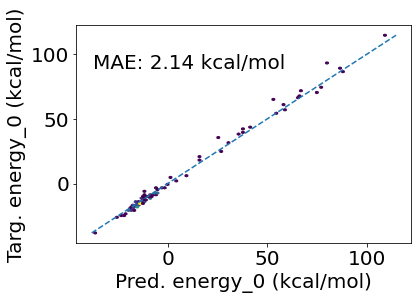

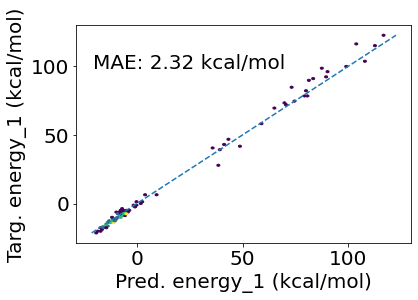

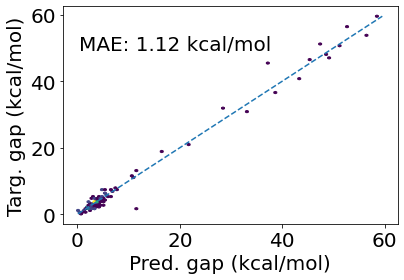

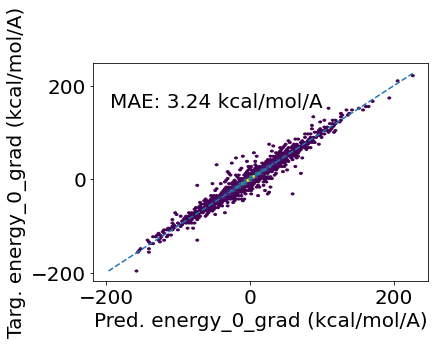

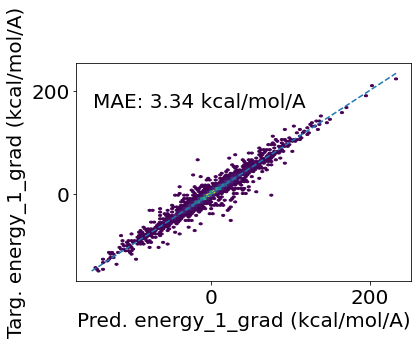

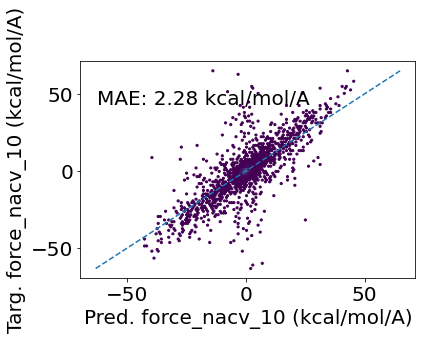

In [9]:
def correct_nacv(results, 
                 targets,
                 key):
    num_atoms = targets['num_atoms']
    if not isinstance(num_atoms, list):
        num_atoms = num_atoms.tolist()
    pred = torch.split(torch.cat(results[key]), num_atoms)
    targ = torch.split(torch.cat(targets[key]), num_atoms)
    
    real_pred = []

    for p, t in zip(pred, targ):
        sub_err = (p - t).abs().mean()
        add_err = (p + t).abs().mean()
        sign = 1 if sub_err < add_err else -1
        real_pred.append(sign * p)
    
    return real_pred
    

def plot(results,
         targets, 
         key,
         units,
         name):
    
    pred = results[key]
    targ = targets[key]
    
    targ_dim = len(targets['energy_0'][0].shape)
    fn = torch.stack if targ_dim == 0 else torch.cat
    pred = torch.cat(pred).reshape(-1)
    targ = fn(targ).reshape(-1)
    
    
    mn = min([pred.min(), targ.min()])
    mx = max([pred.max(), targ.max()])
    ideal = np.linspace(mn, mx, 100)
    ideal = np.linspace(mn, mx, 100)
    
    mae = abs(pred - targ).mean()
    text = f"MAE: %.2f {units[key]}" % (mae)
    
    fig, ax = plt.subplots()
    plt.hexbin(pred,
              targ,
              mincnt=1)
    
    
    plt.xlabel(f"Pred. {name} ({units[key]})", fontsize=20)
    plt.ylabel(f"Targ. {name} ({units[key]})", fontsize=20)
    plt.text(0.05, 0.8, text, transform=ax.transAxes,
            fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
    plt.locator_params(axis='x', nbins=4) 
    plt.locator_params(axis='y', nbins=4) 
    
    plt.plot(ideal, ideal, '--')
    
    plt.show()
    


results, targets, test_loss = evaluate(T.get_best_model(),
                                       test_loader, 
                                       loss_fn=lambda x, y: torch.Tensor([0]), 
                                       device=device)
real_nacv = correct_nacv(results, targets, 'force_nacv_10')
results['force_nacv_10'] = real_nacv


en_keys = ['energy_0', 'energy_1', 'energy_1_energy_0_delta']
grad_keys = ['energy_0_grad', 'energy_1_grad']

units = {key: 'kcal/mol' for key in en_keys}
units.update({key: 'kcal/mol/A' for key in 
              [*grad_keys, 'force_nacv_10']})

key_dic = {'energy_1_energy_0_delta': 'gap'}

for key in [*en_keys, *grad_keys, 'force_nacv_10']:
    name = key_dic.get(key, key)
    plot(results, 
         targets, 
         key,
         units,
         name=name)




The model is off to a good start!